In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
df = pd.read_csv('data/Netflix_Historical_StockPrice2.csv')
df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-03-28,98.339996,101.440002,97.820000,101.209999,101.209999,12432200
1,2016-03-29,101.080002,104.330002,101.000000,104.129997,104.129997,16008900
2,2016-03-30,104.650002,104.910004,101.480003,102.190002,102.190002,14705000
3,2016-03-31,102.430000,103.529999,101.050003,102.230003,102.230003,9747500
4,2016-04-01,102.930000,105.790001,102.470001,105.699997,105.699997,14182400


In [3]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1.260000e+03
mean,292.419810,296.933730,287.681095,292.472302,292.472302,8.451711e+06
std,135.356764,137.677319,132.811799,135.274699,135.274699,5.513675e+06
min,85.430000,86.500000,84.500000,85.330002,85.330002,1.144000e+06
25%,160.012501,161.159996,157.865002,159.867504,159.867504,5.018600e+06
50%,308.220001,313.744995,302.919998,309.014999,309.014999,6.938700e+06
75%,371.059998,376.107498,364.540001,370.585007,370.585007,1.006235e+07
max,582.450012,593.289978,570.400024,586.340027,586.340027,5.841040e+07


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1260 entries, 0 to 1259
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1260 non-null   object 
 1   Open       1260 non-null   float64
 2   High       1260 non-null   float64
 3   Low        1260 non-null   float64
 4   Close      1260 non-null   float64
 5   Adj Close  1260 non-null   float64
 6   Volume     1260 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 69.0+ KB


In [5]:
plt.rcParams['figure.figsize'] = (10, 5)

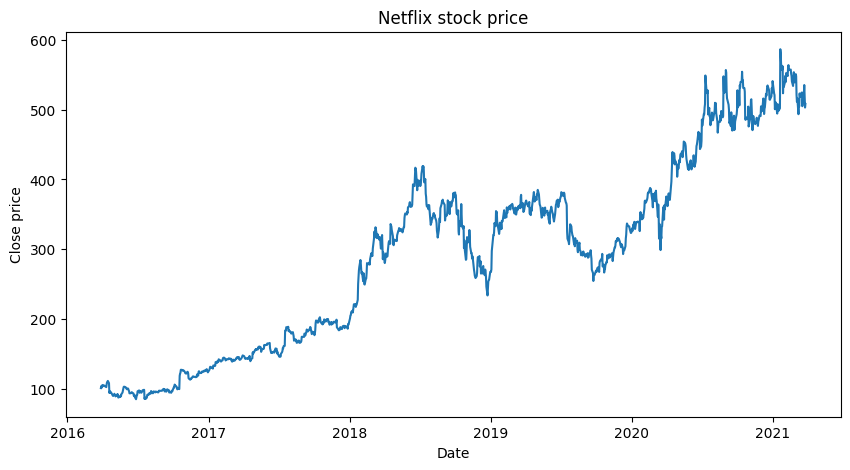

In [6]:
df.Date = pd.to_datetime(df.Date)

plt.plot(df.Date, df.Close)
plt.title('Netflix stock price')
plt.xlabel('Date')
plt.ylabel('Close price')
plt.show()

Non-stationary :(
p-value: 0.9204185709647512 
adf: -0.33486917582775344 
crit: -2.9110731481481484


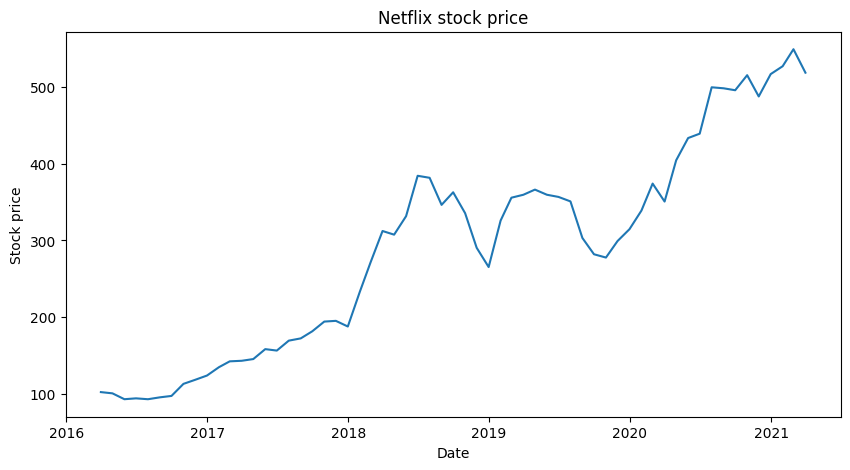

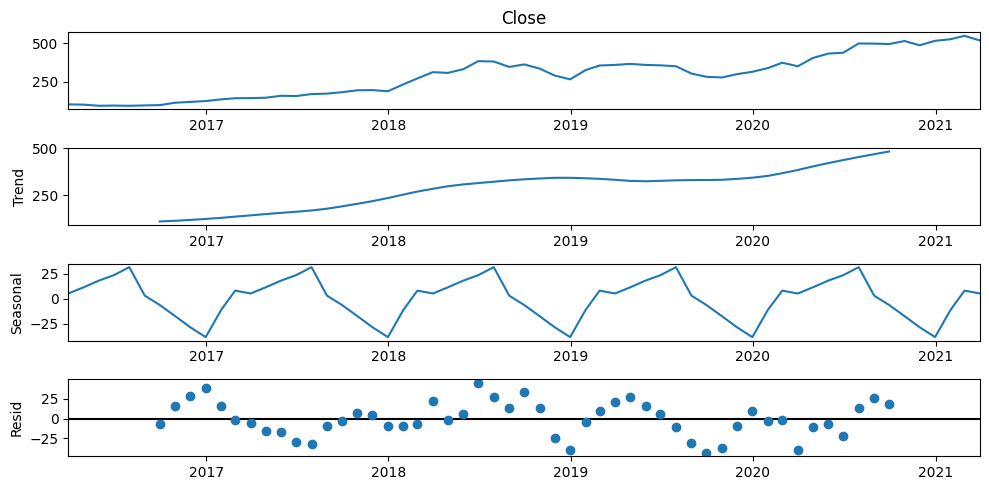

In [7]:
from urllib.robotparser import RequestRate
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

def isStationary(dataset):
    test = sm.tsa.adfuller(dataset)
    adf = test[0]
    pvalue = test[1]
    crit = test[4]['5%']

    if adf <= crit:
        print('Stationary ^_^\np-value:', pvalue)
    else:
        print('Non-stationary :(\np-value:', pvalue, '\nadf:', adf, '\ncrit:', crit)
    plt.plot(dataset)
    plt.title('Netflix stock price')
    plt.xlabel('Date')
    plt.ylabel('Stock price')
    plt.show()

def seasonalDecompose(dataset):
    dataset.index = pd.to_datetime(dataset.index)
    dataset = dataset.asfreq('1m')
    dataset.fillna(method='ffill', inplace=True)

    desomposed = seasonal_decompose(dataset, model='additive')
    desomposed.plot()
    plt.show()


df.set_index('Date', inplace=True)
df.index = pd.to_datetime(df.index)
df = df.resample('1M').mean()

price = df.Close
isStationary(price)
seasonalDecompose(price)

In [8]:
from scipy.special import boxcox, inv_boxcox

Non-stationary :(
p-value: 0.25692848930364853 
adf: -2.0695623930729705 
crit: -2.9110731481481484


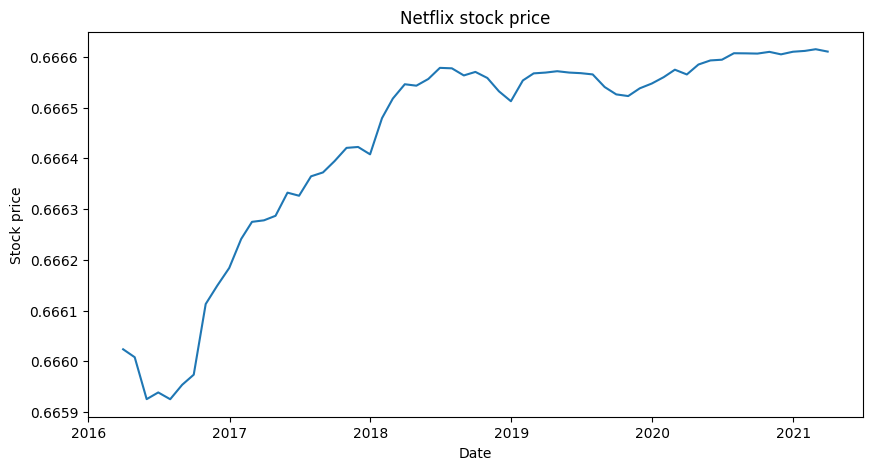

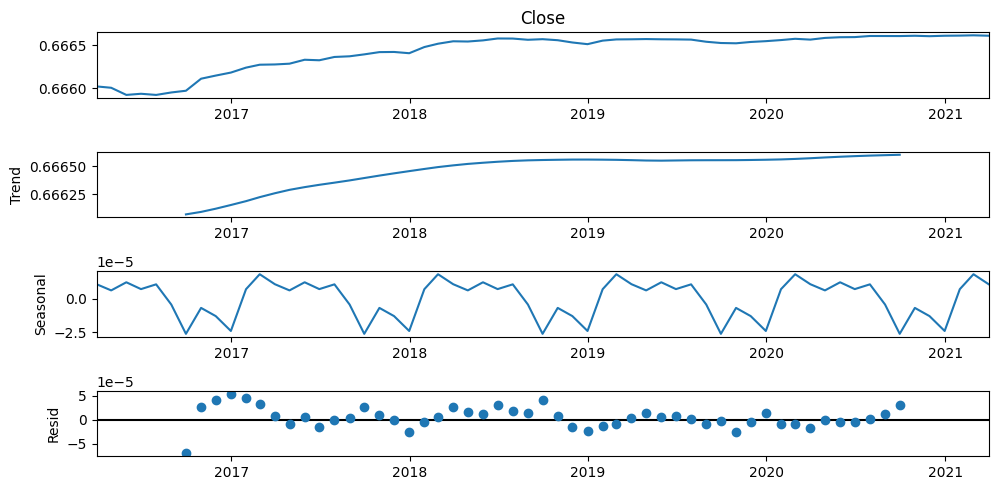

In [9]:
price1 = boxcox(price, -1.5)
price1.fillna(method='ffill', inplace=True)
isStationary(price1)
seasonalDecompose(price1)

Stationary ^_^
p-value: 4.12439156950853e-07


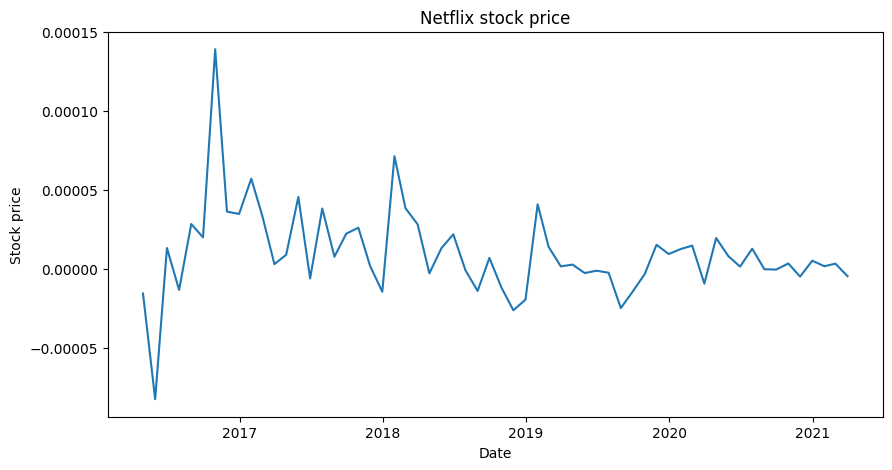

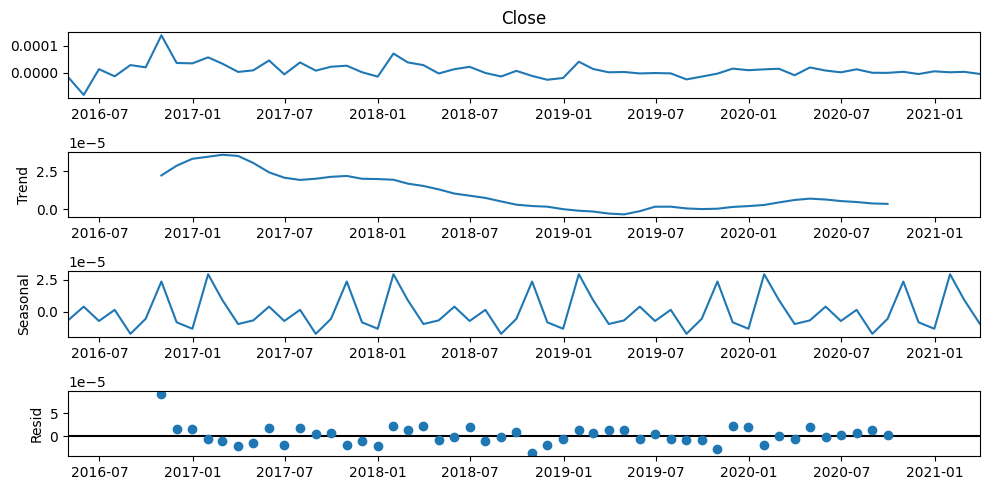

In [10]:
savedFirst = price1[0]
price2 = price1.diff(1)[1:]
isStationary(price2)
seasonalDecompose(price2)

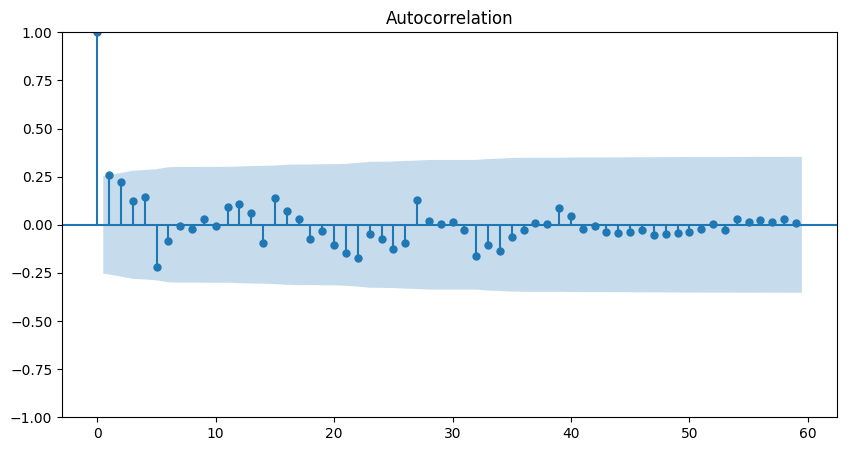

In [11]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(price2, lags=len(price2) - 1)
plt.show()

In [12]:
def recover(dataset):
    return inv_boxcox([savedFirst] + dataset.cumsum(), -1.5)

## Скользящее среднее

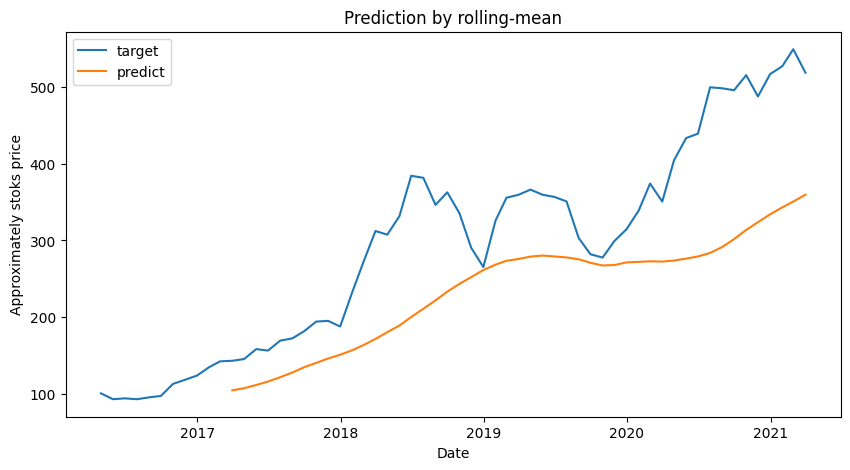

MAPE:  0.411529553640667


In [13]:
data = price2.copy()

test = recover(data)
predict = recover(data.rolling(12).mean())

plt.plot(test, label='target')
plt.plot(predict, label='predict')
plt.title('Prediction by rolling-mean')
plt.xlabel('Date')
plt.ylabel('Approximately stoks price')
plt.legend()
plt.show()

predict.fillna(value=0.0, inplace=True)
print("MAPE: ", mean_absolute_percentage_error(test, predict))

## Модель Хольта-Уинтера

In [14]:
def HoltWinter(data, L, alpha, beta, gamma, trainigSize):
    seasonAmount = int(len(data) // L)
    seasonalities = {} 
    seasonalitiesAvg = [sum(data[L * i: L * i + L]) / float(L) for i in range(seasonAmount)]
    
    for i in range(L):
        seasonSum = 0.0
        for j in range(seasonAmount):
            seasonSum += data[L * j + i] - seasonalitiesAvg[j]
        seasonalities[i] = seasonSum / seasonAmount
        
    result = data.copy()
    
    smoothValue = data[0]
    trendValue = sum([(float(data[j + L] - data[j]) / L) for j in range(L)]) / L 
    result[0] = data[0]

    for i in range(1, len(data)):
        if i >= trainigSize:
            j = i + 1 - len(data)
            result[i] = (smoothValue + j * trendValue) + seasonalities[i % L]
        else:
            smoothValueLast, smoothValue = smoothValue, alpha * (data[i] - seasonalities[i % L]) + (1 - alpha) * (smoothValue + trendValue)
            trendValue = beta * (smoothValue - smoothValueLast) + trendValue * (1 - beta)
            seasonalities[i % L] = gamma * (data[i] - smoothValue) + (1 - gamma) * seasonalities[i % L]
            result[i] = smoothValue + trendValue + seasonalities[i % L]
    
    return result

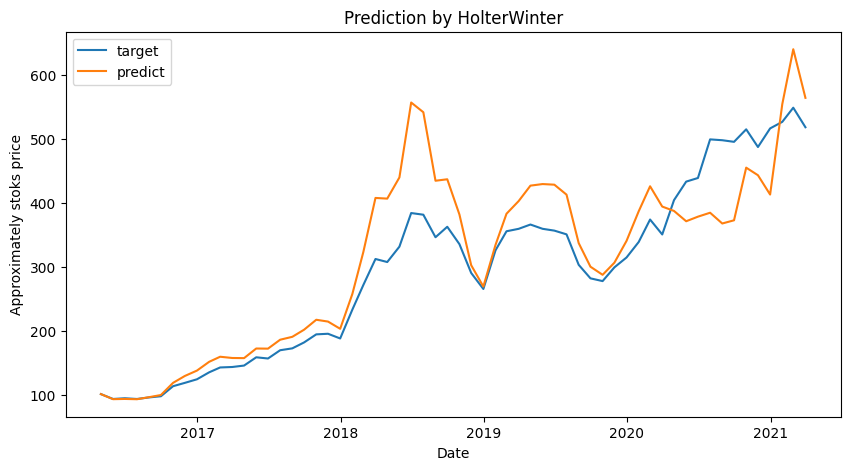

MAPE:  0.12902865298240843


In [40]:
data = price2.copy()

trainigSize = int(len(data) * 0.8)

test = recover(data)
predict = recover(HoltWinter(data, 12, 0.7, 0.4, 0.3, trainigSize))

plt.plot(test, label='target')
plt.plot(predict, label='predict')
plt.title('Prediction by HolterWinter')
plt.xlabel('Date')
plt.ylabel('Approximately stoks price')
plt.legend()
plt.show()

predict.fillna(value=0.0, inplace=True)
print("MAPE: ", mean_absolute_percentage_error(test, predict))

## SARIMA

In [11]:
import pmdarima

In [42]:
model = pmdarima.arima.auto_arima(y=data[:trainigSize],
                                  start_p=0,    # starting lag amount for AR
                                  start_q=0,    # starring value for MA
                                  test='adf',   # stationary test
                                  max_p=20,
                                  max_d=20,    # max season difference size
                                  max_q=20,
                                  start_P=0,
                                  start_Q=0,
                                  seasonal=True,
                                  max_D=20,
                                  m=12,         # period of season
                                  trace=True
                                  )
model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-855.570, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-855.009, Time=0.73 sec


/home/eerov/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-853.202, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-851.699, Time=0.04 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=-854.230, Time=0.52 sec


/home/eerov/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=-853.570, Time=0.28 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=-852.084, Time=0.45 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=-856.775, Time=0.15 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=-854.775, Time=0.63 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=-853.097, Time=0.62 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=-854.842, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=-854.747, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-855.202, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=-853.361, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[12]             : AIC=-855.793, Time=0.04 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 4.081 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   48
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 431.387
Date:                Tue, 29 Nov 2022   AIC                           -856.775
Time:                        18:24:31   BIC                           -851.161
Sample:                    04-30-2016   HQIC                          -854.653
                         - 03-31-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   8.511e-06   4.69e-06      1.814      0.070   -6.83e-07    1.77e-05
ar.L1          0.2561   5.35e-13   4.79e+11      0.000       0.256       0.256
sigma2      8.976e-10   3.49e-10      2.575      0.010    2.15e-10    1.58e-09
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                73.11
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               0.14   Skew:                             1.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.68e+26. Standard errors may be unstable.
"""

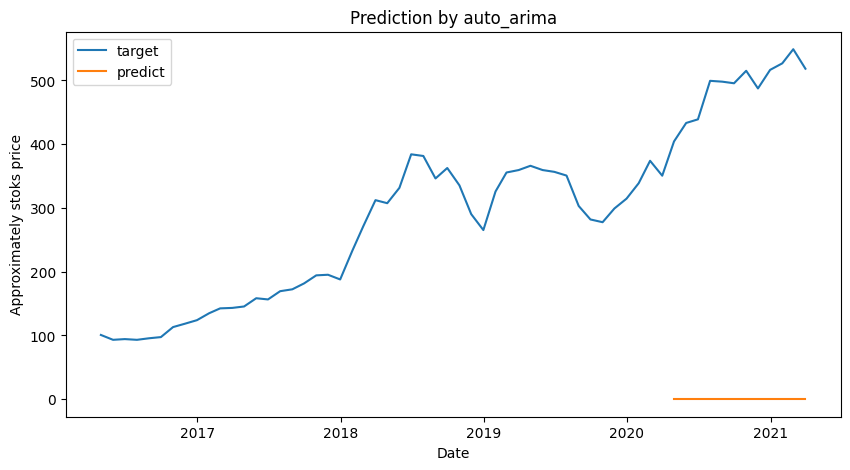

MAPE:  0.999999977932413


In [43]:
predict = model.predict(n_periods=len(data) - trainigSize)

plt.plot(test, label='target')
plt.plot(predict, label='predict')
plt.title('Prediction by auto_arima')
plt.xlabel('Date')
plt.ylabel('Approximately stoks price')
plt.legend()
plt.show()

predict.fillna(value=0.0, inplace=True)
print("MAPE: ", mean_absolute_percentage_error(test[-len(predict):], predict))

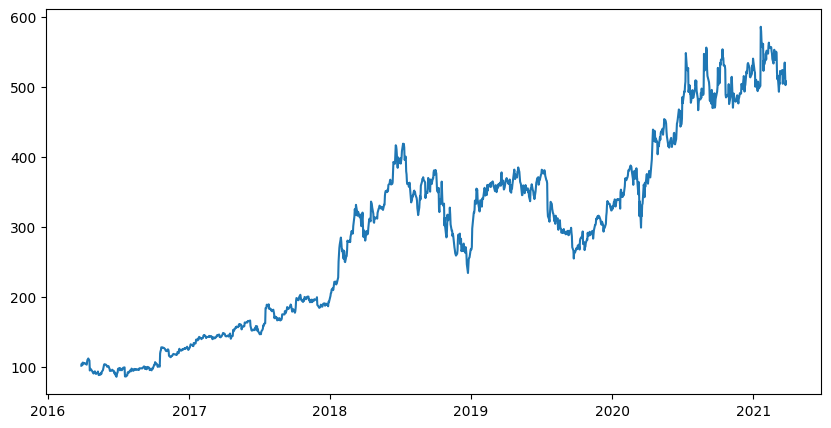

In [6]:
df = pd.read_csv('data/Netflix_Historical_StockPrice2.csv')
df.Date = pd.to_datetime(df.Date)
df.set_index('Date', inplace=True)
df.index = pd.to_datetime(df.index)

plt.plot(df.Close)

df1 = df.Close

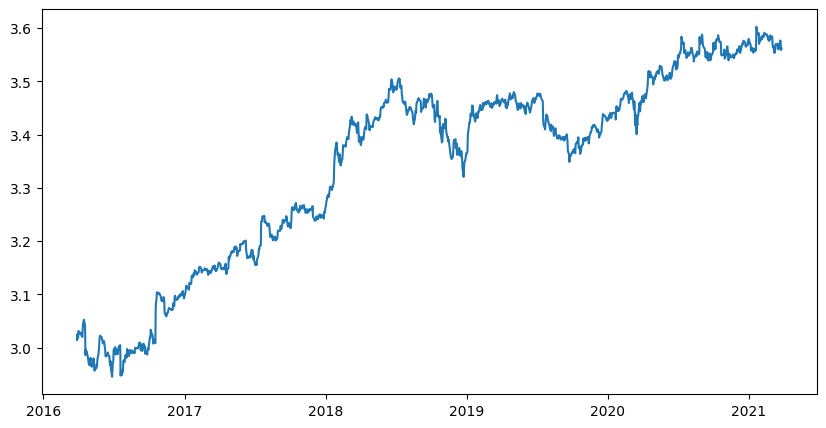

In [9]:
df2 = boxcox(df1, -0.2)
df2.fillna(method='ffill', inplace=True)

plt.plot(df2)

In [46]:

dayTrainigSize = int(len(df2) * 0.8)

large_model = pmdarima.arima.auto_arima(y=df2[:dayTrainigSize],
                                        start_p=0,    # starting lag amount for AR
                                        start_q=0,    # starring value for MA
                                        test='adf',   # stationary test
                                        max_p=100,
                                        max_d=100,    # max season difference size
                                        max_q=100,
                                        start_P=2,
                                        start_Q=2,
                                        seasonal=True,
                                        max_D=100,
                                        m=12,         # period of season
                                        trace=True
                                      )
large_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=-6741.912, Time=5.68 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-6748.144, Time=0.14 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-6747.146, Time=1.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-6746.943, Time=2.05 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-6747.372, Time=0.11 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-6747.292, Time=0.58 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-6747.346, Time=1.47 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=-6744.964, Time=2.76 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-6747.933, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=-6747.689, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=-6744.546, Time=0.16 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12] intercept
Total fit time: 14.495 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1008
Model:               SARIMAX(0, 1, 0)   Log Likelihood                3376.072
Date:                Tue, 29 Nov 2022   AIC                          -6748.144
Time:                        18:24:46   BIC                          -6738.314
Sample:                             0   HQIC                         -6744.409
                               - 1008                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0004      0.000      1.666      0.096   -7.86e-05       0.001
sigma2      7.169e-05   1.34e-06     53.534      0.000    6.91e-05    7.43e-05
===================================================================================
Ljung-Box (L1) (Q):                   1.79   Jarque-Bera (JB):              3698.26
Prob(Q):                              0.18   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                            -0.06
Prob(H) (two-sided):                  0.12   Kurtosis:                        12.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/home/eerov/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


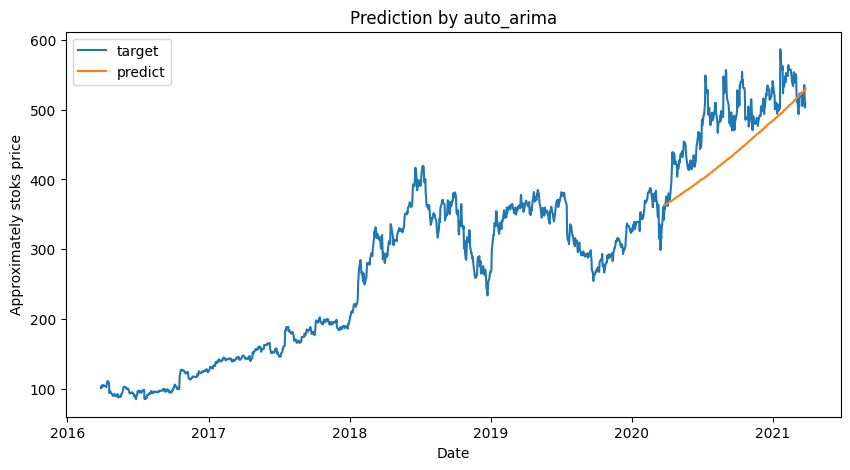

MAPE:  0.0995361531716307


In [47]:
predict = large_model.predict(n_periods=len(df2) - dayTrainigSize)
predict.index = df2.index[-len(predict):]

test = inv_boxcox(df2, -0.2)
predict = inv_boxcox(predict, -0.2)

plt.plot(test, label='target')
plt.plot(predict, label='predict')
plt.title('Prediction by auto_arima')
plt.xlabel('Date')
plt.ylabel('Approximately stoks price')
plt.legend()
plt.show()

predict.fillna(value=0.0, inplace=True)
print("MAPE: ", mean_absolute_percentage_error(test[-len(predict):], predict))

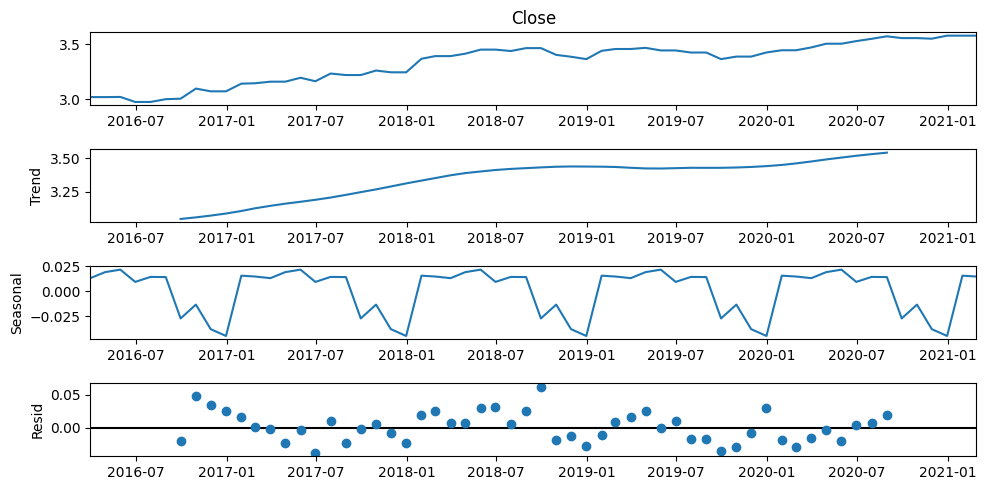

In [48]:
seasonalDecompose(df2)

In [12]:

dayTrainigSize = int(len(df2) * 0.8)

large_model_weekly = pmdarima.arima.auto_arima(y=df2[:dayTrainigSize],
                                        start_p=0,    # starting lag amount for AR
                                        start_q=0,    # starring value for MA
                                        test='adf',   # stationary test
                                        max_p=2,
                                        max_d=2,    # max season difference size
                                        max_q=2,
                                        start_P=0,
                                        start_Q=0,
                                        seasonal=True,
                                        max_D=2,
                                        m=52,         # period of season
                                        trace=True
                                      )
large_model_weekly.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=-6748.144, Time=0.20 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=-6748.624, Time=10.90 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=-6748.562, Time=20.85 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=-6747.372, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=-6747.933, Time=0.16 sec
 ARIMA(1,1,0)(2,0,0)[52] intercept   : AIC=-6747.253, Time=100.79 sec
 ARIMA(1,1,0)(1,0,1)[52] intercept   : AIC=-6746.243, Time=6.69 sec
 ARIMA(1,1,0)(0,0,1)[52] intercept   : AIC=-6748.795, Time=13.08 sec
 ARIMA(1,1,0)(0,0,2)[52] intercept   : AIC=-6746.855, Time=20.97 sec
 ARIMA(1,1,0)(1,0,2)[52] intercept   : AIC=-6744.894, Time=97.96 sec
 ARIMA(0,1,0)(0,0,1)[52] intercept   : AIC=-6748.395, Time=23.45 sec
 ARIMA(2,1,0)(0,0,1)[52] intercept   : AIC=-6750.571, Time=11.58 sec
 ARIMA(2,1,0)(0,0,0)[52] intercept   : AIC=-6750.116, Time=0.28 sec
 ARIMA(2,1,0)(1,0,1)[52] intercept   : AIC=-6748.574, Time=10.62

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1008
Model:             SARIMAX(2, 1, 0)x(1, 0, 0, 52)   Log Likelihood                3380.556
Date:                            Tue, 29 Nov 2022   AIC                          -6751.112
Time:                                    19:33:50   BIC                          -6726.538
Sample:                                         0   HQIC                         -6741.775
                                           - 1008                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.000      1.696      0.090   -7.09e-05       0.001
ar.L1         -0.0406      0.027     -1.523      0.128      -0.093       0.012
ar.L2          0.0668      0.029      2.300      0.021       0.010       0.124
ar.S.L52      -0.0586      0.031     -1.899      0.058      -0.119       0.002
sigma2      7.097e-05   1.33e-06     53.447      0.000    6.84e-05    7.36e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              3726.66
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                            -0.10
Prob(H) (two-sided):                  0.09   Kurtosis:                        12.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/home/eerov/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


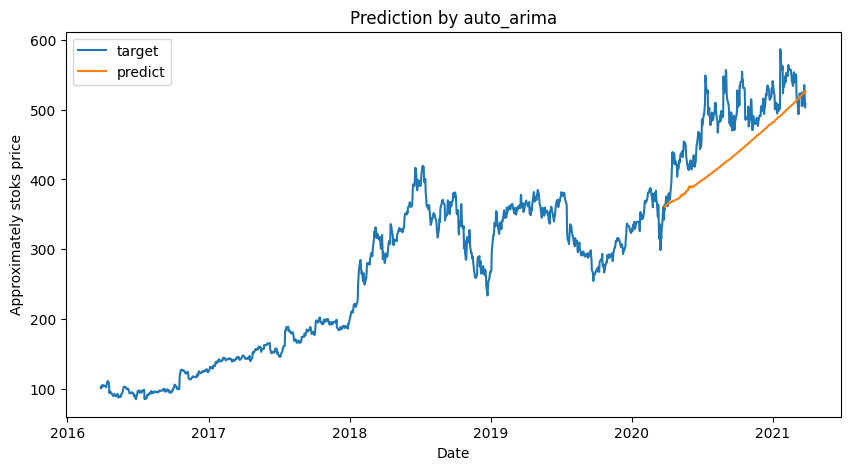

MAPE:  0.10300922598562244


In [13]:
predict = large_model_weekly.predict(n_periods=len(df2) - dayTrainigSize)
predict.index = df2.index[-len(predict):]

test = inv_boxcox(df2, -0.2)
predict = inv_boxcox(predict, -0.2)

plt.plot(test, label='target')
plt.plot(predict, label='predict')
plt.title('Prediction by auto_arima')
plt.xlabel('Date')
plt.ylabel('Approximately stoks price')
plt.legend()
plt.show()

predict.fillna(value=0.0, inplace=True)
print("MAPE: ", mean_absolute_percentage_error(test[-len(predict):], predict))